
# Summary

Today, we're going to be implementing least squares regression subject to a bound on *total variation*. That is, we're going to find a curve $\hat \mu$ on $[0,1]$ that solves this optimization problem.

$$
\begin{aligned}
\hat \mu &= \operatorname*{argmin}_{\substack{m \\ \rho_{TV}(m) \le B}} \frac{1}{n}\sum_{i=1}^n \{ Y_i - m(X_i) \}^2 \qquad \text{ where } \\  & \rho_{TV}(m) = \max_{\substack{\text{increasing sequences} \\ 0=x_1 \le x_2 \le \ldots \le x_k=1}}
                  \sum_{j=1}^{k-1} \left\lvert m(x_{j+1})-m(x_j) \right\rvert.
\end{aligned}
$$

This is going to be a lot like implementing monotone regression. In fact, I changed only three lines of my implementation of monotone regression. And two of those are boilerplate. I'll give you those, so ultimately the change you'll be writing is a one-liner.

But there is another issue that we didn't have to deal with before. We have to choose a sensible value of the variation budget $B$. We'll take a look at how this impacts the curve we get and consider *cross-validation* as a strategy for choosing it automatically.

We'll use a few libraries.


In [1]:
suppressPackageStartupMessages({
    library(tidyverse)
    library(CVXR)
})

# OSQP claims some feasible problems aren't, so we'll tell CVXR not to use it
CVXR::add_to_solver_blacklist('OSQP')  

# We'll give our plots a transparent background
lab.theme = theme(panel.background = element_rect(fill='transparent'),          
                  plot.background = element_rect(fill='transparent', color=NA),  
                  legend.background = element_rect(fill='transparent'),         
                  legend.box.background = element_rect(fill='transparent'))

# Implementation

Much like we did with monotone regression, it'll help to start with a constraint defined on the sample. In particular, we'll work with a seminorm $\hat\rho_{TV}$ which, instead of being defined as a maximum over all increasing sequences, uses a single increasing sequence: the observations $X_1 \le X_2 \le \ldots \le X_n$, which we will assume we have sorted into increasing order throughout. That is, we'll solve this finite-dimensional optimization problem.

$$
\begin{aligned}
\hat \mu &= \operatorname*{argmin}_{\substack{m \\ \hat\rho_{TV}(m) \le B}} 
            \frac{1}{n}\sum_{i=1}^n \{ Y_i - m(X_i) \}^2 \qquad \text{ where } \\ 
&\hat\rho_{TV}(m) = \sum_{i=1}^{n-1} \left\lvert m(X_{i+1})-m(X_i) \right\rvert.
\end{aligned}
$$ 

As in the analogous problem we discussed when doing monotone regression, both our squared error and our constraint depend only on the values $m(X_1) \ldots m(X_n)$ of $m$. And if we have the values $\hat\mu^{\text{sample}}(X_1) \ldots \hat\mu^{\text{sample}}(X_n)$ of a solution to this problem, we can easily find a solution to our original problem. In fact, you already have code to do it. Let me explain.

## From Bounded Variation on the Sample to Bounded Variation

The short answer is that we can take $\hat \mu(x)$ to be any curve that agrees with $\hat \mu^{\text{sample}}$ at $X_1 \ldots X_n$, is *monotone* between the observations, and is *constant* outside the range of the data. Typically, we use piecewise-constant interpolation, defining $\hat \mu(x)$ to be $\hat \mu^{\text{sample}}(X_i)$ where $X_i$ is the closest observation to the left of $x$ if $x$ is inside the range of the data and the leftmost observation otherwise: $X_i=\max\ \{X_i : X_i \le x\} \cup \{X_1\}$. That's what the function `predict.piecewise.constant` we've been using with monotone regression does.

Here's why this gives us a solution to our original problem. The explanation is based on three observations.

1.  Any curve we're considering in our original optimization also gets considered in our finite-dimensional analog. That is, $\hat\rho_{TV}(m) \le \rho_{TV}(m)$ for any curve $m$ and therefore $$ \left\{ m : \rho_{TV}(m) \le B\right\} \subseteq \left\{ m : \hat\rho_{TV}(m) \le B \right\} $$ We know this because $\hat\rho_{TV}(m)$ is the sum $\sum_{i=1}^{n-1} \left\lvert m(X_{i+1})-m(X_i) \right\rvert$ for a particular increasing sequence $X_1 \ldots X_n$ and $\rho_{TV}(m)$ the maximum of *the same sum* over all increasing sequences $X_1 \ldots X_n$.

2.  This implies that any curve $\hat\mu$ that solves our original optimization would be considered in our finite-dimensional analog, so the prediction error that we're minimizing in both problems, $\text{MSPE}(m)=\frac{1}{n}\sum_{i=1}^n \{ Y_i - m(X_i) \}^2$, is *at least as small* at a solution $\hat\mu_{\text{sample}}$ to the finite-dimensional version as it is in the original problem. Consequently, if a solution $\hat\mu_{\text{sample}}$ to our finite-dimensional problem satisfies the stronger constraint $\rho_{TV}(m) \le B$ needed to be considered in the original problem, it's also a solution to the original problem: it has the smallest $\text{MSPE}$ among curves in the set $\left\{ m : \hat\rho_{TV}(m) \le B \right\}$, so it must have the smallest $\text{MSPE}$ among any subset of those curves, including $\left\{ m : \rho_{TV}(m) \le B \right\}$.

3.  For any curve $m^{\text{sample}}$, we can find a curve $m$ that *agrees on the sample*, i.e. with $m(X_i) = m^{\text{sample}}(X_i)$, that has total variation *equal to* its sample total variation. The piecewise-constant curve we've been drawing is one of them: all of its variation is at the sample points. Furthermore, because it agrees with $m^{\text{sample}}$ on the sample, it has the same $\text{MSPE}$. That means the piecewise-constant curve we've proposed through the points $\hat\mu^{\text{sample}}(X_i)$ is a solution to the finite-dimensional problem and satisfies the stronger constraint imposed in the original problem. Thus, it's a solution to the original problem.

To reinforce your understanding of this argument, do this exercise. We'll work with a sample of three points $(X_i,Y_i)$. $$ \left\{\left(0, \frac{1}{2}\right), \left(\frac{1}{2},0\right), \left(1,\frac{1}{4}\right)\right\} $$You can think of what we'll be doing as stepping through our approach to bounded variation regression in a world in which there are only six curves: $m_1(x)=x^2$, $m_2(x) = 3(x-1/2)^2$, $m_3(x) = 2(x-3/4)^2$, and corresponding piecewise-constant curves $\tilde m_1$, $\tilde m_2$, and $\tilde m_3$



Draw each of these six curves. I suggest you draw three plots in total: one of $m_1$ and $\tilde m_1$ together, another of $m_2$ and $\tilde m_2$, and another of $m_3$ and $\tilde m_3$. For each, calculate the sample total variation $\hat\rho_{TV}(m)$ and the total variation $\rho_{TV}(m)$. Then answer these questions.

Of these curves, which minimize mean squared prediction error among the curves with $\hat\rho_{TV}(m) \le 1$? And which minimize it among the curves with $\rho_{TV}(m) \le 1$?


While I recommend you draw these by hand, I'll draw them in R. That way, I don't have to distribute images in addition to this notebook. I'll draw $m_1,m_2,m_3$ as solid lines and $\tilde m_1, \tilde m_2, \tilde m_3$ as dashed lines.


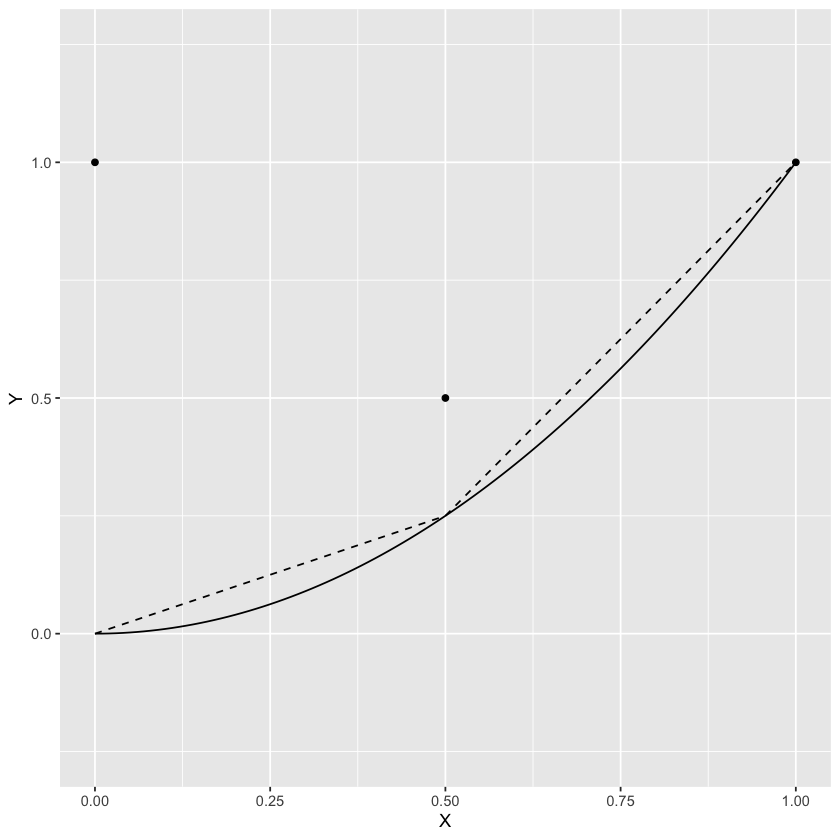

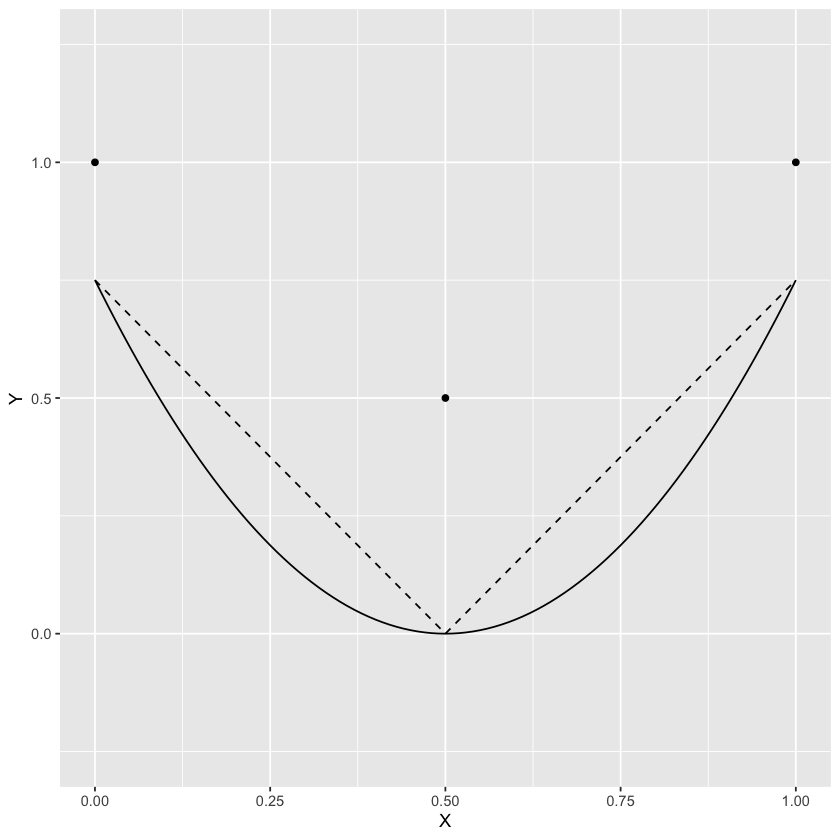

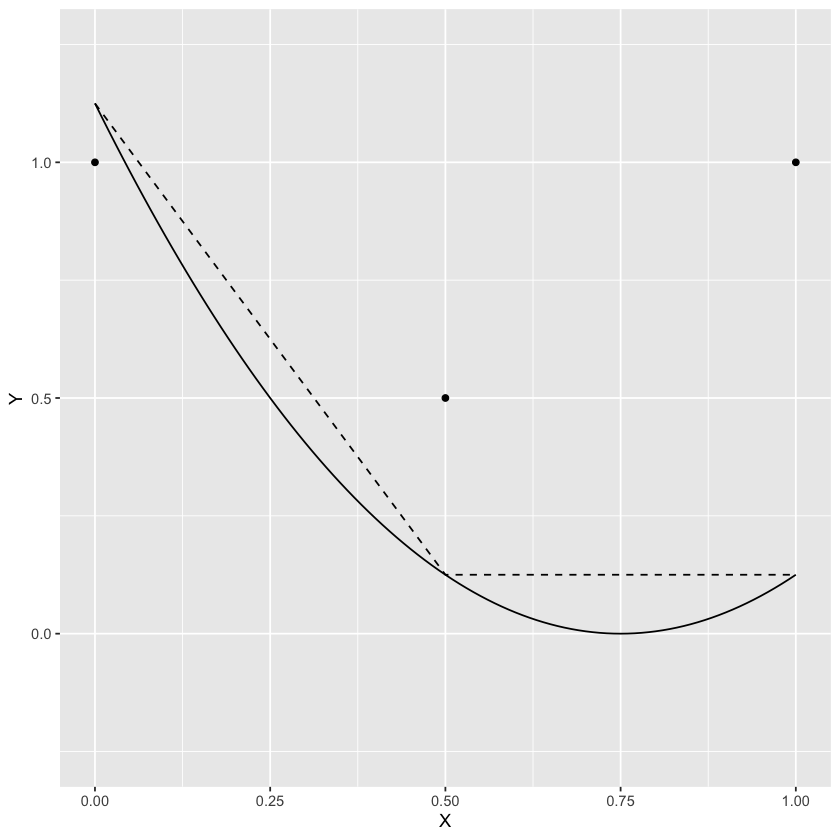

In [2]:

x = seq(0,1, by=.01)
X = c(0,1/2,1)
Y = c(1,1/2,1)

observations = ggplot() + geom_point(aes(x=X, y=Y)) + ylim(-.25,1.25)

observations + geom_line(aes(x=x,y=x^2)) + 
               geom_line(aes(x=X,y=X^2), linetype=2)
observations + geom_line(aes(x=x,y=3*(x-1/2)^2)) + 
               geom_line(aes(x=X,y=3*(X-1/2)^2), linetype=2)
observations + geom_line(aes(x=x,y=2*(x-3/4)^2)) + 
               geom_line(aes(x=X,y=2*(X-3/4)^2), linetype=2)

Here's a table of $\rho_{TV}(m)$, $\hat\rho_{TV}(m)$, and $\text{MSPE}(m)$. When looking at the denominators, keep in mind that the height of a grid cell in the plot above is 1/4, which explains the 1/16s, and the height of half of one is 1/8, which explains the 1/64s.



$$
\begin{array}{llll}
m   & \rho_{TV}(m) & \hat\rho_{TV}(m) & \text{MPSE}(m) \\
\hline
m_1 &  1 & 1 & \frac{17}{16} \\
\tilde m_1 & 1 & 1 & \frac{17}{16} \\ 
m_2 &  \frac{3}{2} & \frac{3}{2} & \frac{6}{16} \\
\tilde m_2 & \frac{3}{2} & \frac{3}{2} & \frac{6}{16} \\
m_3 &  \frac{20}{16}   & 1 &  \frac{59}{64} \\
\tilde m_3 & 1 & 1 & \frac{59}{64}
\end{array}
$$ We can see from the table that $m_3$ and $\tilde m_3$ minimize $\text{MSPE}(m)$ among curves with $\hat\rho_{TV}(m) \le 1$. They have a lower value of $\text{MSPE}(m)$ than $m_1$ and $\tilde m_1$; $m_2$ and $\tilde m_2$, having $\hat\rho_{TV}(m) > 1$, are not eligible. Furthermore, $\tilde m_3$ minimizes $\text{MSPE}(m)$ among curves with $\rho_{TV}(m)\le 1$, as $m_3$, having $\rho_{TV}(m) > 1$, is not eligible.



## Solving the Finite-dimensional Problem

All this leaves is finding the values $\hat\mu_{\text{sample}}(X_i)$ of a solution to the finite-dimensional optimization problem. As in the Monotone Regression Lab, we can almost get away with substituting the elements $\vec m_i$ of a vector $\vec m \in \mathbb{R}^n$ for the function values $m(X_1) \ldots m(X_n)$. The one wrinkle is that we need to make sure these elements correspond to the values of a function, i.e., that the vector satisfies $\vec m_i = \vec m_j$ if $X_i=X_j$. That is,


$$
\hat \mu(X_i) = \vec \mu_i \ \text{ where } \ \vec \mu = 
\operatorname*{argmin}_{\substack{\vec m \in \mathbb{R}^n \\
                   \sum_{i=1}^{n-1} \left\lvert \vec m_{i+1} - \vec m_i\right\rvert \le B 
                   \\ \vec m_{i+1} = \vec m_i \ \text{ for all $i$ with $X_{i+1}=X_i$}}}               
                   \frac{1}{n}\sum_{i=1}^n (Y_i - \vec m_i)^2. 
$$


We covered this in the Optimized Implementation Section of the Monotone Regression Lab.

This is a very similar optimization to the one we used for monotone regression. We're still optimizing over a vector $\vec{m}$ of $n$ values with the interpretation $\vec{m}_i=m(X_i)$. We're still minimizing mean squared prediction error. All we've got to do is change our constraint. 
To save you some trouble, I've copied my monotone regression code into the block below. And I've handled some boilerplate changes for you, too.

1.  I've changed the name and arguments of the function (line 1).
2.  I've changed the 'class' attribute in the output so *R* knows it's a bounded variation regression rather than a monotone one (line 36).
3.  I've defined 'predict.tvreg' to do piecewise-constant interpolation like we did in the monotone regression lab (line 72).

That means that all you have to do is change the constraint. The one that's on lines 20-21.

In [3]:
tvreg = function(X,Y, B=1) {
  # reorder pairs (Xi,Yi) so Xs are sorted: X[i] <= X[i+1] <= ...
  X.orig = X
  increasing.order=order(X)
  n = length(X)
  Y = Y[increasing.order]
  X = X[increasing.order]
  
  # now we're going to optimize over the values of m(X1)...m(Xn),
  # which we think of as a vector in R^n with m[i] = m(Xi).
  # first, we tell CVXR we're thinking about a vector m in R^n
  m = Variable(n) 

  # then, we tell it what function of m we're minimizing
  mse = sum((Y - m)^2) / n
  
  # and give it a list of constraints we want imposed on m
  # here we minimize mean squared error subject to the constraint 
  # its total variation is at most B
  monotone.constraint = list(diff(m) >= 0)
  constraints = c(monotone.constraint, function.constraint(m,X))

  # solve and ask for m that solves our minimization problem using the re-ordered data
  solved = solve(Problem(Minimize(mse), constraints))
  mu.hat.increasing.order = solved$getValue(m)
  
  # put the result back in the original order.
  mu.hat = array(dim=n)
  mu.hat[increasing.order] = mu.hat.increasing.order
  
  # now a little boilerplate to make it idiomatic R 
  #  1. we record the input X and the solution mu.hat in a list
  #  2. we assign that list a class, so R knows predict should delegate to predict.monotonereg
  #  3. we return the list
  model = list(X=X.orig, mu.hat=mu.hat, B=B)
  attr(model, "class") = "tvreg"
  model
}

# generate the constraint that m(Xi) = m[i] defines a function of Xi
# that is, if X[i+1]=X[i], impose the constraint that m[i+1]=m[i]
# this function assumes X is sorted in increasing order
function.constraint = function(m, X) {
    repeated=which(duplicated(X))
    if(length(repeated) == 0) { list() } 
    else { list(m[repeated]==m[repeated-1]) }
}

# make predictions based on piecewise-constant interpolation
# we use the curve that jumps at each observation and is otherwise constant
# that is, if X[1] < X[2] < ..., 
#   mu.hat(x) for x between X[k] and X[k+1] is mu.hat(X[k])   [case 1]
#             for x > X[k]  is mu.hat(X[k])                   [case 2]
#             for x < X[1]  is mu.hat(X[1])                   [case 3]
predict.piecewise.constant = function(model, newdata=data.frame(X=model$X)) {
  increasing.order = order(model$X) 
  X = model$X[increasing.order]
  mu.hat = model$mu.hat[increasing.order]
  
  # for each new data point x[k]
  # find the closest observed X[i[k]] left of x[k]
  # i.e., i[k] is the largest integer i for which X[i] <= x[k] 
  # this covers cases 1 and 2
  i = findInterval(newdata$X, X) 
  # if there is no X[i] < x[k], findInterval sets i[k]=0
  # to cover case 3, we want X[i] for i=1 when this happens.
  i[i==0] = 1
  # report the values of mu.hat(X[k]), one for each x
  mu.hat[i]
}

predict.tvreg = predict.piecewise.constant
prediction.function = function(model) { 
  if(class(model)=='function') { model }
  else{ function(x) { predict(model, newdata=data.frame(X=x)) } }
}


Once you've got code, try fitting some data to see that it works. You can just run this block, but it might be instructive to try changing the variation budget $B$ and look at how the fit changes. Or try changing the function $\mu$ from the step to something else and see how the fit changes.

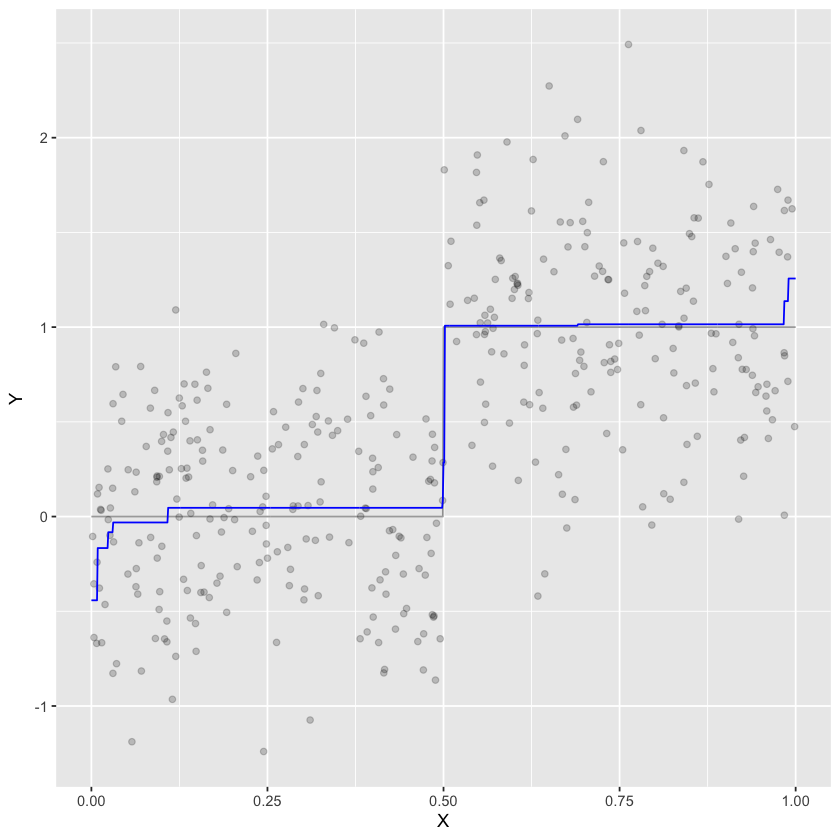

In [4]:


mu = function(x) { 1*(x >= .5) }
sigma = .5
n = 400
X = runif(n)
Y = mu(X) + sigma*rnorm(n)

x = seq(0,1,by=.001) 
mu.hat = prediction.function(tvreg(X,Y, B=1))
ggplot() + geom_point(aes(x=X,y=Y), alpha=.2) +
           geom_line(aes(x=x, y=mu(x)), alpha=.4) +
           geom_line(aes(x=x,y=mu.hat(x)), color='blue')


# Behavior

Now that we've got some bounded variation regression code, let's see how it works and how that depends on the variation budget $B$. We'll try fitting data sampled around four simple curves. Data that looks like this.

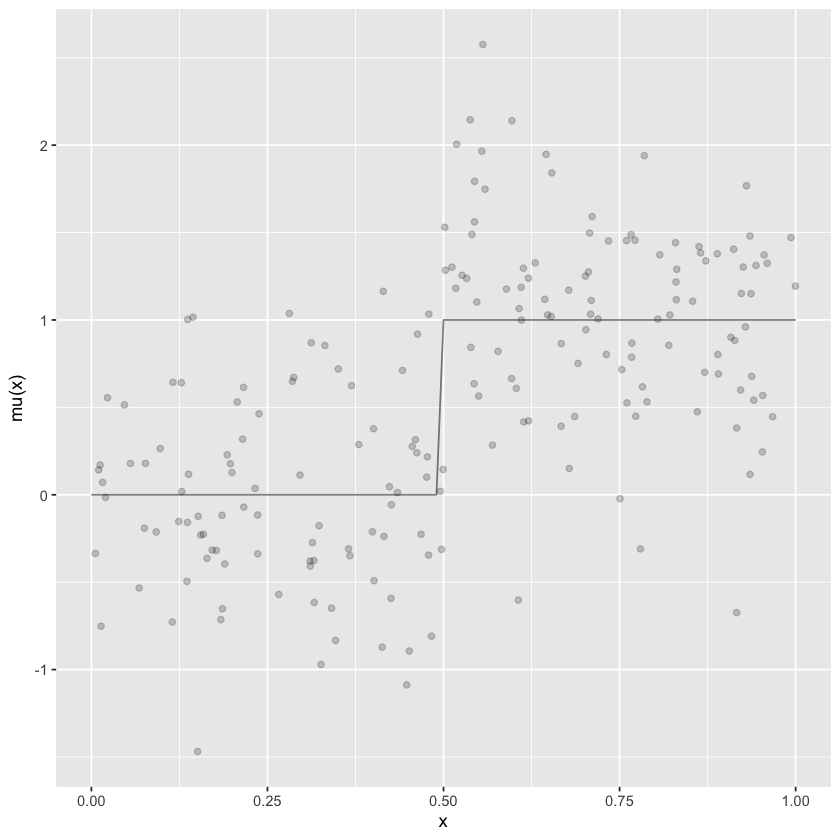

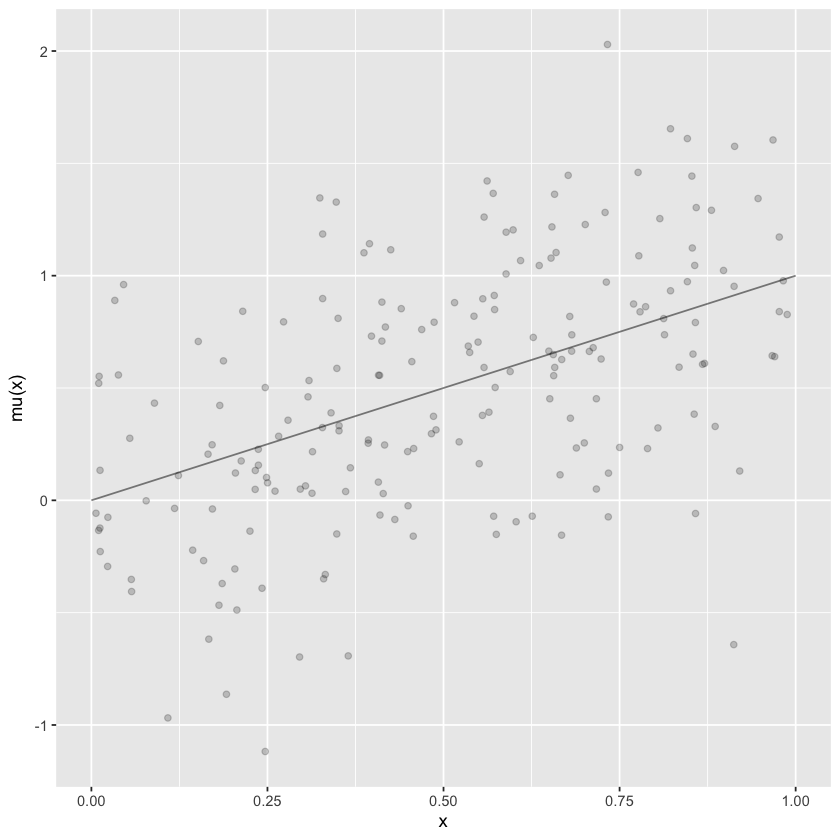

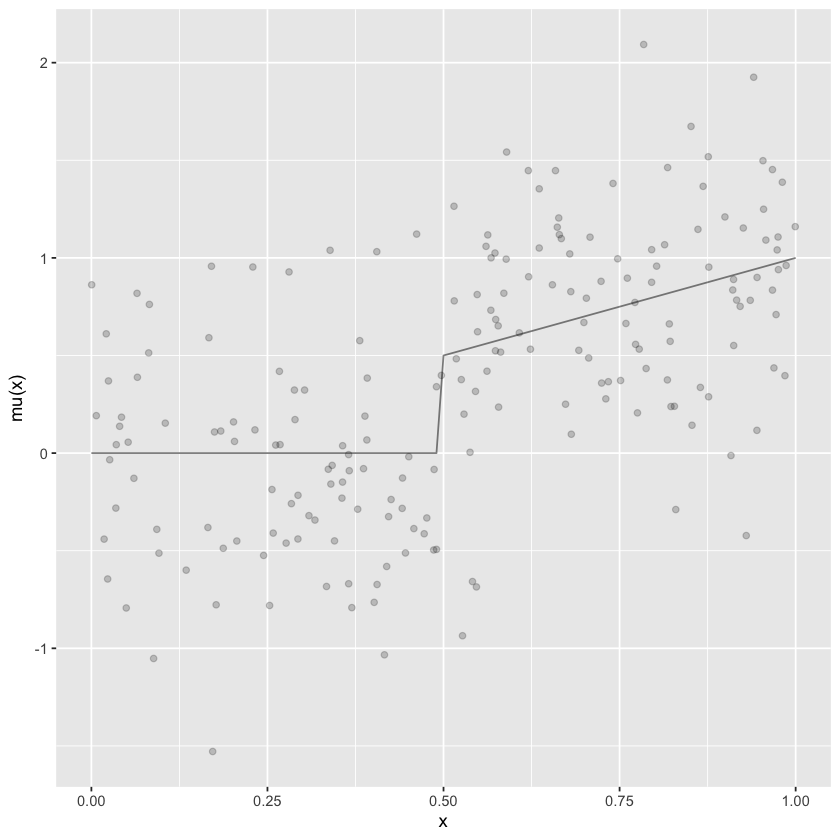

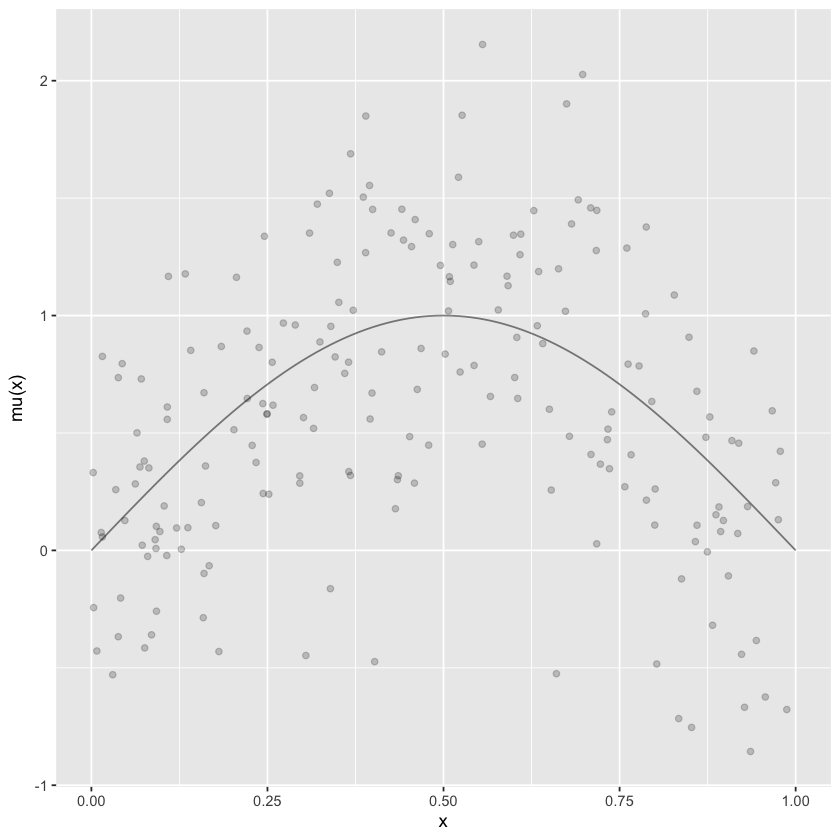

In [5]:
n=200
sigma = .5
mus = list(step     = function(x) { 1*(x >= .5) },
	         line     = function(x) { x },
	         stepline = function(x) { x*(x >= .5) }, 
	         sin      = function(x) { sin(pi*x) })
           
x = seq(0,1,by=.01)
for(mu.name in names(mus)) { 
    mu = mus[[mu.name]]
    X     = runif(n)
    epsilon     = sigma*rnorm(length(X))
    Y = mu(X) + epsilon
    print(ggplot() + 
      geom_line(aes(x=x, y=mu(x)), alpha=.5) + 
        geom_point(aes(x=X, y=Y), alpha=.2))  
}



For each curve $\mu$, we'll do the following.

1.  Sample $n=200$ some observations $(X_i,Y_i)$ with

    -   $X_i$ uniformly distributed on $[0,1]$
    -   $Y_i = \mu(X_i) + \varepsilon_i$ where $\varepsilon_i \sim N(0,\sigma^2)$ for $\sigma=.5$.

    And sample independent copies $(\tilde X_i,\tilde Y_i)$ from the same distribution.

2.  Use our code to find estimates $\hat\mu$ of the curve using variation budgets $B \in \{1/10,\ 1/4,\ 1/2,\ 1,\ 2,\ 4,\ 10\}$.

3.  For each of these estimates, calculate

    -   Training Error, $\frac1n\sum_{i=1}^n \{ \hat\mu(X_i) - Y_i \}^2$
    -   Test Error, $\frac1n\sum_{i=1}^n \{ \hat\mu(\tilde X_i) - \tilde Y_i \}^2$
    -   Population MSE, $\int_0^1 \{ \hat\mu(x) - \mu(x)\}^2 dx + \sigma^2$.  

    Adding $\sigma^2$ to the last error makes it comparable to the others, which are sensitive to the noise level.

We'll do it all 10 times and average the results to get a decent approximation to the expectation of each of these error measures. Let's run the blocks below to tabulate there errors. It will take a few minutes.

In [6]:
training.error = function(mu.hat, d) { 
  mean((mu.hat(d$X)-d$Y)^2)
}
test.error     = function(mu.hat, d) { 
  mean((mu.hat(d$Xtest)-d$Ytest)^2)
}
population.mse = function(mu.hat, d) { 
  x=seq(0,1,by=.001)
  mean((mu.hat(x) - d$mu(x))^2) + sigma^2
}   
errors = list(training=training.error, 
              test=test.error, 
              population=population.mse)

Bs = c(.1,.25,.5,1,2,4,10)
models = Bs |> 
  map(\(B) \(X,Y) tvreg(X,Y,B)) |> 
  set_names(sprintf('tv=%1.2f', Bs))



In [7]:
on_sample = function(f, mu, sigma, n) {
    X     = runif(n)
    Xtest = runif(n)
    epsilon     = sigma*rnorm(length(X))
    epsilontest = sigma*rnorm(length(X))
    Y = mu(X) + epsilon
    Ytest = mu(Xtest) + epsilontest
    dataset = list(mu=mu,X=X,Y=Y,Xtest=Xtest,Ytest=Ytest)
    f(dataset)
}

summarize_fit = function(models) {
  function(d) {
    map(models, \(fit.model) { 
      model = fit.model(d$X,d$Y)
      mu.hat = prediction.function(model)
      errors |> map(\(e) data.frame(error=e(mu.hat, d))) |>
                list_rbind(names_to='error.measure') |>
                mutate(B=model$B)
    }) |> list_rbind(names_to='model')
  }
} 

In [8]:
tab = 1:10 |> map(\(rep) { 
  mus |> map(\(mu) 
  summarize_fit(models) |> 
  on_sample(mu, sigma, n)
  ) |> list_rbind(names_to='mu')
}) |> list_rbind(names_to='rep') 


Here's what we get.


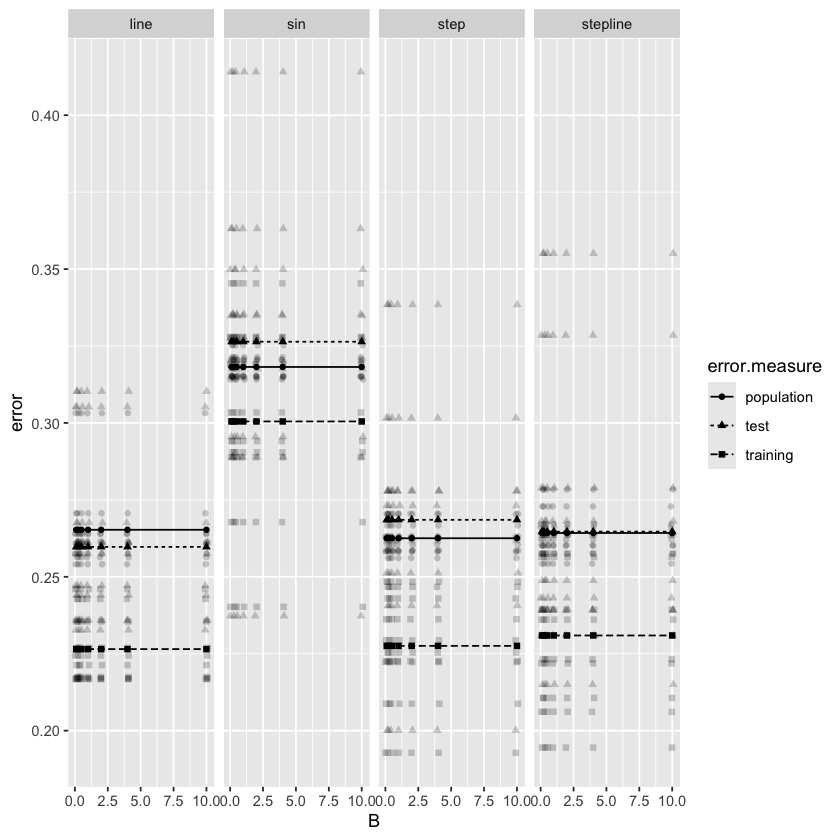

In [9]:

ggplot(tab, 
       aes(x=B, y=error, linetype=error.measure, shape=error.measure)) + 
  geom_point(alpha=.2, position=position_jitter(w=.1)) + 
  stat_summary(geom='line',  fun=mean) +
  stat_summary(geom='point', fun=mean) +
  facet_grid(cols=vars(mu))




### Why Test Error and Population MSE agree so well

What we see in this plot is that Test Error and $\text{Population MSE} + \sigma^2$ are very close. That means we can effective choose our variation budget $B$ to minimize Population MSE. 
That's something we can't compute in practice because we'd need knowledge of $\mu$ and the distribution of $X$ to do it, but because test error tracks it so well, we get the same effect by choosing $B$ to minimize test error.
Test Error is, in fact, an *unbiased* estimate of $\text{Population MSE} + \sigma^2$. This is a pretty straightforward calculation. Letting $\tilde E$ denote expectation conditional on the training observations ...

$$
\begin{aligned}
\tilde{E} \{ \tilde Y_i - \hat\mu(\tilde X_i)\}^2 
&= \tilde{E} \{\tilde \varepsilon_i + \mu(\tilde X_i) - \hat \mu(\tilde X_i)\}^2 \quad \text{ for } \quad \tilde \varepsilon_i = \tilde Y_i - \mu(\tilde X_i) \\ 
&= \tilde{E} \tilde\varepsilon_i^2 + \tilde{E} \{\mu(\tilde X_i) - \hat\mu(\tilde X_i)\}^2 +
  2\tilde{E} \tilde \varepsilon_i \{\mu(\tilde X_i) - \hat\mu(\tilde X_i)\} \\
&= \sigma^2 + \text{PMSE} + 0
\end{aligned}
$$

Unbiasedness is, of course, not the whole story. Some unbiased estimates are usually nowhere near the quantity they're estimating. But this isn't just an unbiased estimate. It's an *average* of $n$ independent terms, each of which is an unbiased estimate of the same quantity. 
Roughly how far apart, as a function of sample size $n$, would you expect them to be? Does what you say require the noise $\varepsilon_i$ to be independent of $X_i$ or is it true in greater generality?.

*Hint.* What is the expectation of adjusted test error conditional on the training observations? And what is the conditional variance?

## Overfitting

Explain why training error tends to zero as $B$ increases. Why does test error not have this problem?

# Model selection

Since the variation budget $B$ matters, it's important to choose it well. Ideally, we'd do it automatically. Give it a shot.
Propose and implement an automated approach to choosing the variation budget $B$ in the block below.

**Hint**. Do we have an error measure that is both sensible and computable? To keep things simple, I'll ask that you choose from a finite set of options $\{B_1 \ldots B_k\}$. 

In [10]:

select.budget = function(X,Y,Bs) {
  max(Bs) # You can do better than this
}


Let's see how well this works. We'll look at error varies as a function of sample size for bounded variation regression with a few fixed budgets, as well as with a budget chosen by this procedure.
To do this, we'll make a table of errors at different sample sizes, then do some visualization. Since everything is random, we'll do all this 10 times, average the results, and take a look at how variable these results are. 

Run the block below to make the table. It may take a few minutes. Keep in mind that if you haven't finished some of the previous exercises, the results you'll get might look pretty odd.
For example, if your version of the function `tvreg` above is really just monotone regression, varying the budget won't do anything. And if you haven't implemented the model selection procedure, you'll just get a comparison of the fixed budget-approaches. 

In [11]:
on_samples = function(f, mu, sigma, ns) {
    X     = runif(max(ns))
    Xtest = runif(max(ns))
    epsilon     = sigma*rnorm(length(X))
    epsilontest = sigma*rnorm(length(X))
    Y = mu(X) + epsilon
    Ytest = mu(Xtest) + epsilontest
    ns |> map(\(n) {
      dataset = list(mu=mu,X=X[1:n],Y=Y[1:n],Xtest=Xtest[1:n],Ytest=Ytest[1:n])
      f(dataset) |> mutate(n=n)
    }) |> list_rbind()
}
tvmodel = function(B) { function(X,Y) { tvreg(X, Y, B=B) }}
tvselected = function(Bs) {
  function(X,Y) { 
    B = select.budget(X,Y,Bs)
    tvreg(X,Y,B=B)
  }
}
models  = list(tv0.5      = tvmodel(.5),
               tv1        = tvmodel(1),
               tv2        = tvmodel(2),
               tv4        = tvmodel(4),
               tvselected = tvselected(c(.5,1,2,4)))


ns = c(25,50,100)
grid = expand_grid(rep=1:10, mu=names(mus))
tab = grid |> 
  pmap(\(rep, mu) on_samples(summarize_fit(models), mus[[mu]], sigma, ns) |> mutate(rep=rep, mu=mu)) |>
  list_rbind() 


Now run this block to plot the error curves for each of our models. What we're seeing in bold color are the means of our error measures plus/minus one standard error. This gives us a sense of which method performs best of average.
To illustrate how random performance is---how much it varies when we repeat the experiment---we'll also plot the error curves for each of our 10 trials faintly. This is called a *spaghetti plot*---they tend to be a bit of a mess,
but they do give you an opportunity to get a gestalt impression of what's going on without committing to any particular summary statistic.

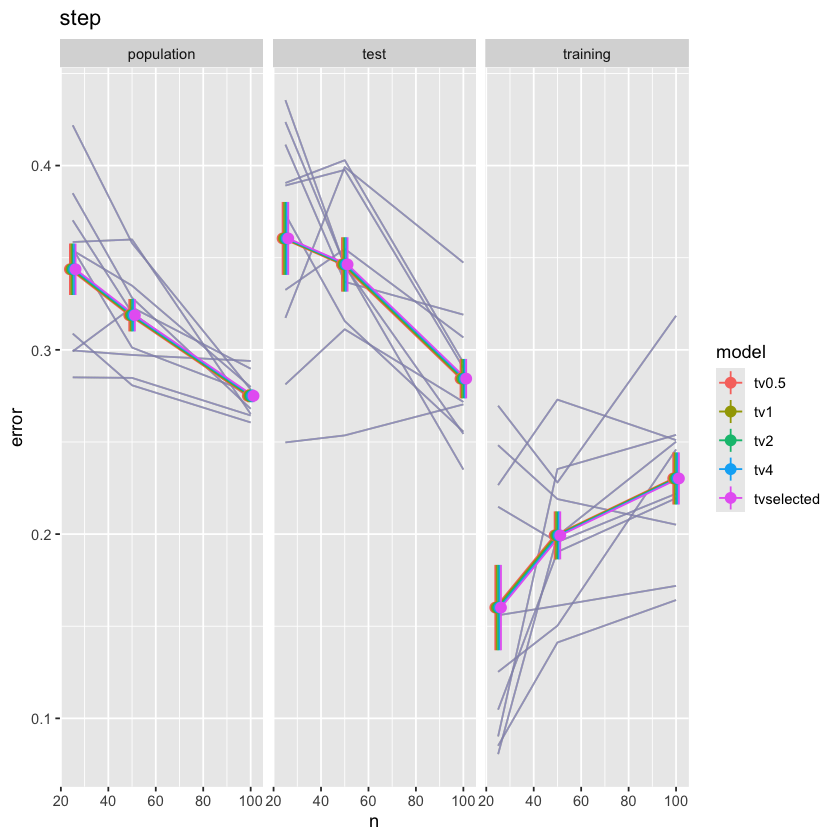

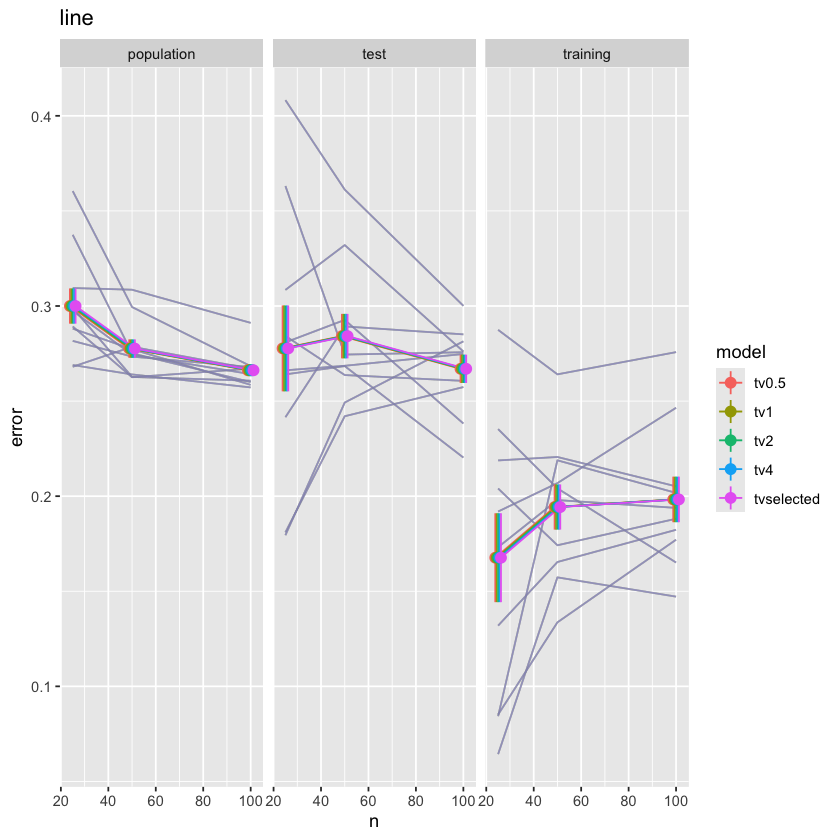

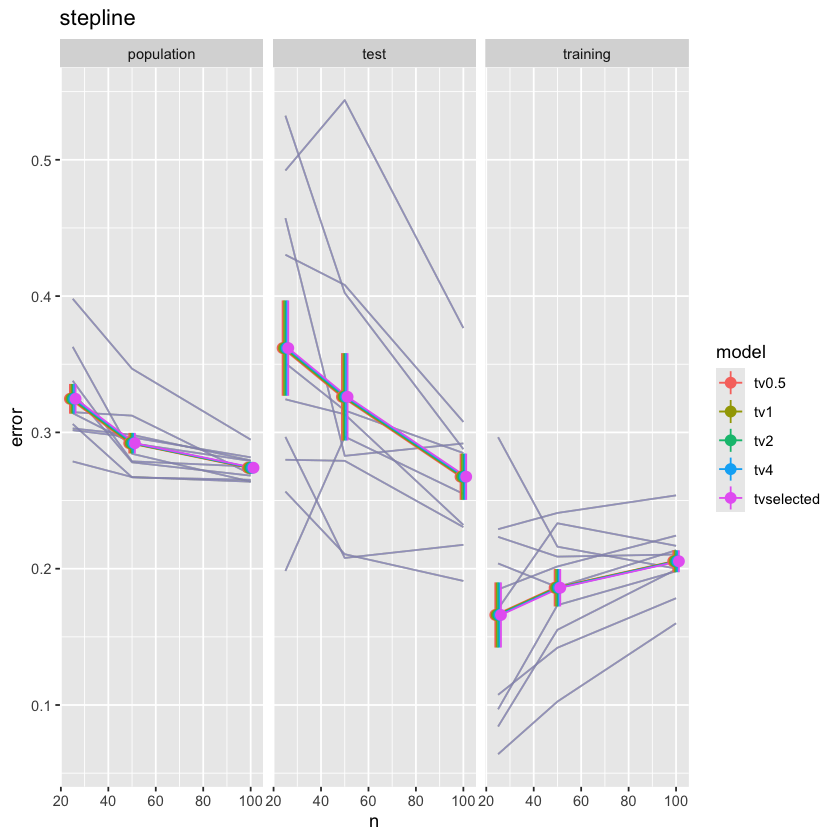

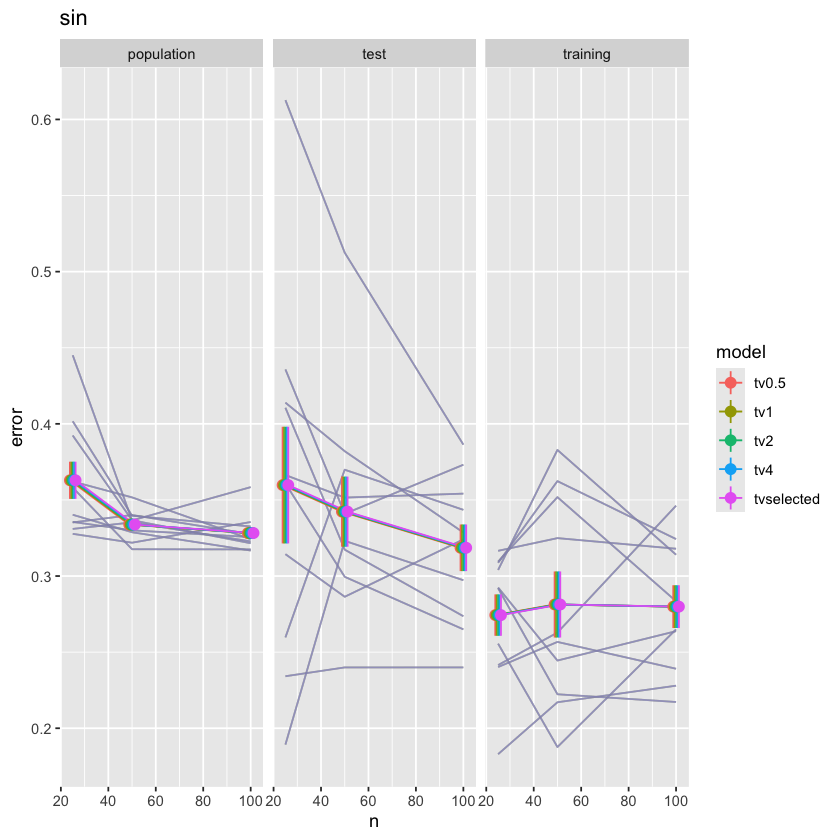

In [12]:
for(mu in names(mus)) {
  plot.data = tab[tab$mu == mu, ]
  print(ggplot(plot.data, aes(x=n, y=error, color=model)) + 
    geom_line(aes(group=interaction(model,rep), color=model), alpha=.3, linewidth=.5) +
    stat_summary(geom='line',  fun=mean, position=position_dodge(width = 3)) +
    stat_summary(geom='pointrange', fun.data=mean_se, position=position_dodge(width=3)) +
    facet_grid(cols=vars(error.measure)) + ggtitle(mu))
}


How does your model selection code perform relative to the other methods? Does it tend to come in first, second, etc in terms of its accuracy? Why? 